## 3: Regression

Eva Dyer, BMED 6517
___


In this lecture, we will study:
* least-squares regression,
* ridge regression,
* sparse regression (LASSO)

#### 1. Dataset

<p><strong>Data Set Characteristics:</strong></p>

<p>Ten baseline variables, age, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
*quantitative measure of disease progression one year after baseline*.</p>


<div><dl class="field-list simple">
<dt class="field-odd">Number of Instances</dt>
<dd class="field-odd"><p>442</p>
</dd>
<dt class="field-even">Number of Attributes</dt>
<dd class="field-even"><p>First 10 columns are numeric predictive values</p>
</dd>
<dt class="field-odd">Target</dt>
<dd class="field-odd"><p>Column 11 is a quantitative measure of disease progression one year after baseline</p>
</dd>
<dt class="field-even">Attribute Information</dt>


*   **age** - age in years
*   **sex** - discrete variable
* **bmi** - body mass index
*  **bp** - average blood pressure
* **tc** - (s1) total serum cholesterol
* **ldl** - (s2) low-density lipoproteins
* **hdl** - (s3) high-density lipoproteins
* **tch** - (s4) total cholesterol / HDL
* **ltg** - (s5) possibly log of serum triglycerides level
* **glu** - (s6) blood sugar level

<p>Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times <code class="docutils literal notranslate"><span class="pre">n_samples</span></code> (i.e. the sum of squares of each column totals 1).</p>
<p>Source URL:
<a class="reference external" href="https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html">https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html</a></p>
<p>For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) “Least Angle Regression,” Annals of Statistics (with discussion), 407-499.
(<a class="reference external" href="https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf">https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf</a>)</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
diabetes = datasets.load_diabetes()

In [2]:
feature_names = diabetes['feature_names']
X = diabetes['data']
y = diabetes['target']

print('Feature names:', feature_names)
print('Number of samples:', X.shape[0])

Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Number of samples: 442


**Splitting the dataset into a train and test set**

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### 2. Least-squares regression

Linear Regression fits a linear model with coefficients
 to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:

 $$\min_{\beta} || X \beta - y||_2^2$$

 In a previous lecture we saw how to derive the LS estimator:

$$\widehat{\beta} = (X^T X)^{+}X^T y$$


##### 2.1. Fit the model to a single feature

We're already familiar with `sklearn` API. We can use the `LinearRegression` class to define parameters, fit training data and predict a measure of the disease progress. To begin, we can *fit the model to a single feature*, the BMI.


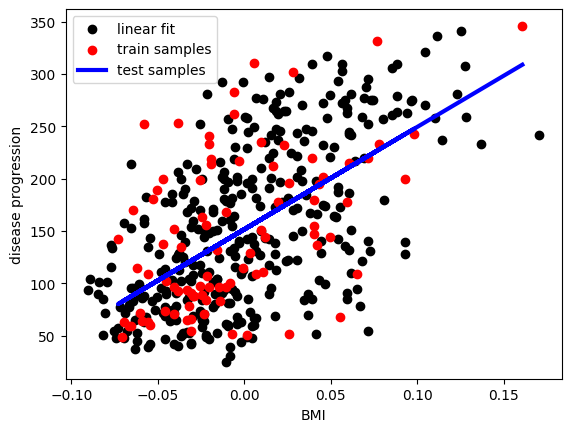

In [4]:
bmi_train = X_train[:, 2:3]
bmi_test = X_test[:, 2:3]

# create linear regression object
regr = linear_model.LinearRegression()

# fit training samples
regr.fit(bmi_train, y_train);

# predict on test samples
y_test_pred = regr.predict(bmi_test)

plt.scatter(bmi_train, y_train,  color='black')
plt.scatter(bmi_test, y_test,  color='red')
plt.plot(bmi_test, y_test_pred, color='blue', linewidth=3)
plt.xlabel('BMI'); plt.ylabel('disease progression')
plt.legend(['linear fit', 'train samples', 'test samples'])
plt.show()


**Model details:**

This linear model deals with one feature only, it has the following equation:
$$\hat y(x) = a x + b$$

When `.fit` is called, the model will find the slope $a$ and the intercept $b$ that minimize the squared error over the training samples.

The parameters are saved in the `regr` object as attributes `coef_` and `intercept_` for $a$ and $b$ respectively.

In [5]:
print('Slope: %.2f' % regr.coef_[0])
print('Intercept: %.2f' % regr.intercept_)

Slope: 977.74
Intercept: 151.67


##### 2.2. Accuracy measures

The linear regression model is now fit to the data. It can be used on any sample to predict the corresponding $y$, using `.predict()`

We can compute the **mean squared error** or the **coefficient of determination** on the training set and the testing set.

Recall that the coefficient of determination or the $R^2$ is defined as:
$$ R^2 = 1 - \frac{\sum_{i} (y_i - \widehat{y}_i)^2}{\sum_{i} (y_i - \bar{y})^2},$$
where $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$ and $\widehat{y}_i$ is the prediction for the $i^{\rm th}$ sample.


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# Metrics on the training set
y_train_pred = regr.predict(bmi_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

# Metrics on the test set
y_test_pred = regr.predict(bmi_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 3867.94
Train set: coefficient of determination: 0.36
Test set: mean squared error: 3989.83
Test set: coefficient of determination: 0.25


#### 3. Least-squares (Multi-features)

We find that the linear model doesn't perform well on the test set. While this indicates that the model does not generalize well yet. To improve the performance of our predictive model, we can use all of the features we have at our disposal.



##### 3.1 Take a closer look at the features

In [7]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(np.hstack([X_train, y_train[:, np.newaxis]]), columns=feature_names + ['y'])
sns.pairplot(df, hue='y', diag_kind=None)

Output hidden; open in https://colab.research.google.com to view.

##### 3.2. Fit a linear regression model to all features

In [8]:
# create linear regression object
regr = linear_model.LinearRegression()

# fit training samples
regr.fit(X_train, y_train);

In [9]:
y_train_pred = regr.predict(X_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

y_test_pred = regr.predict(X_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 2835.04
Train set: coefficient of determination: 0.53
Test set: mean squared error: 2992.58
Test set: coefficient of determination: 0.44


##### 3.3. The performance of the model increased. Let's take a look at the weights assigned to each feature:

Intercept: 151.43


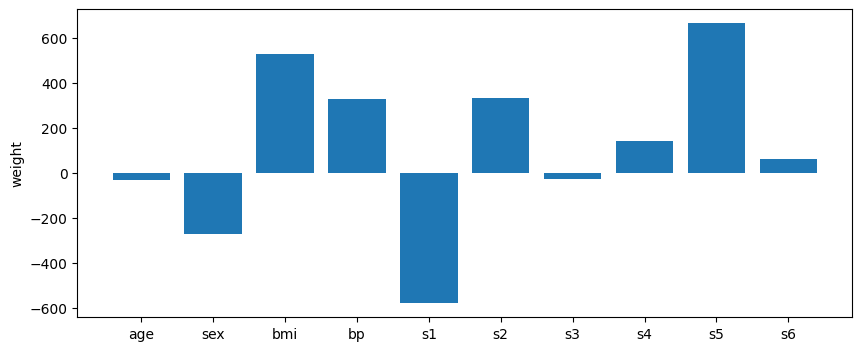

In [10]:
plt.figure(figsize=(10, 4))
plt.bar(feature_names, regr.coef_)
plt.ylabel('weight')
print('Intercept: %.2f' % regr.intercept_)

#### 4. Ridge Regression

$$\min_{\beta} || X \beta - y||_2^2 + \alpha ||\beta||_2^2$$

The complexity parameter  $\alpha$ controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.


##### 4.1 Apply ridge to diabetes dataset

Now let's apply the ridge estimator to our data from before.

In [11]:
regr = linear_model.Ridge(alpha=0.5)

# fit training samples
regr.fit(X_train, y_train);

In [12]:
y_train_pred = regr.predict(X_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

y_test_pred = regr.predict(X_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 3064.63
Train set: coefficient of determination: 0.50
Test set: mean squared error: 3106.27
Test set: coefficient of determination: 0.42


##### 4.2. What happens as we increase the amount of regularization?

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(25, 4))

for i, alpha in enumerate([0.1, 0.5, 1.0, 10.0]):
    regr = linear_model.Ridge(alpha=alpha)
    regr.fit(X_train, y_train)

    axs[i].bar(feature_names, regr.coef_)
    axs[i].set_ylim([-260, 530])
    axs[i].set_title('alpha=%.1f' % alpha)
axs[0].set_ylabel('weight')
plt.show()

### 5. Lasso

Instead of regularizing with the L2-norm, we can use other p-norms. When we use the L1-norm, this regularized estimator is called the LASSO (or Basis Pursuit Denoising, BPDN).

$$\min_{\beta} \frac{1}{2}||X \beta - y||_2 ^ 2 + \lambda ||\beta ||_1$$

##### 5.1 Apply LASSO to diabetes data

In [14]:
regr = linear_model.Lasso(alpha=0.5)

# fit training samples
regr.fit(X_train, y_train);

y_train_pred = regr.predict(X_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

y_test_pred = regr.predict(X_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 3216.75
Train set: coefficient of determination: 0.47
Test set: mean squared error: 3179.05
Test set: coefficient of determination: 0.40


##### 5.2. Varying regularization strength

Let's examine the impact of regularization on the coefficients obtained via the LASSO.

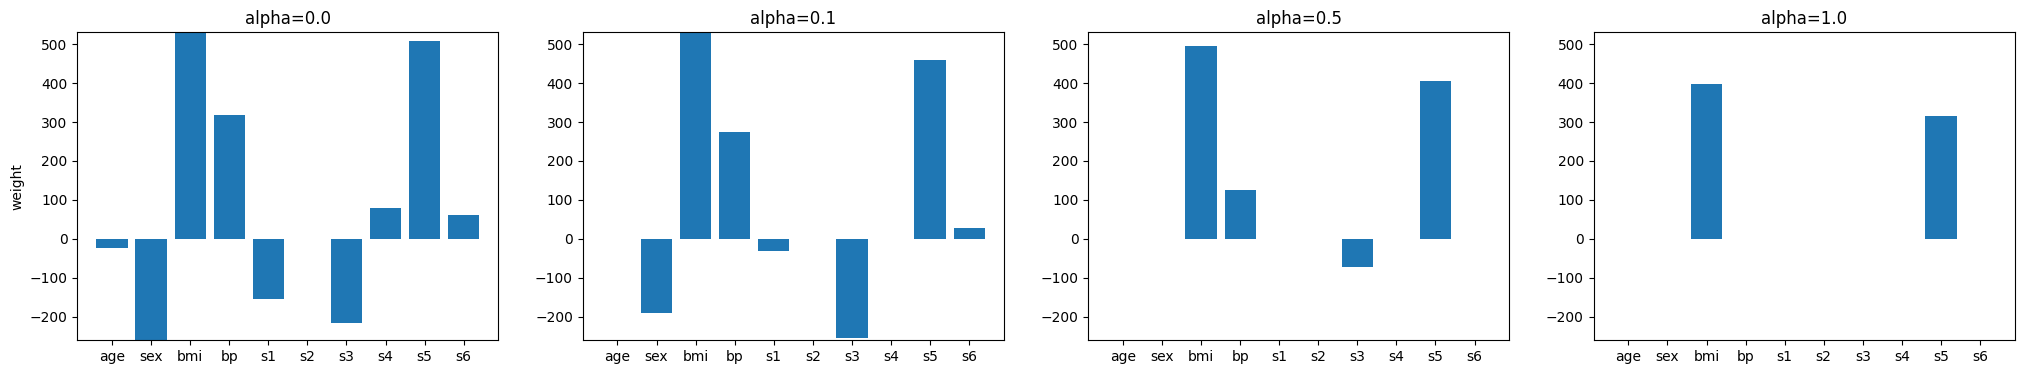

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(25, 4))

for i, alpha in enumerate([0.01, 0.1, 0.5, 1.0]):
    regr = linear_model.Lasso(alpha=alpha)
    regr.fit(X_train, y_train)

    axs[i].bar(feature_names, regr.coef_)
    axs[i].set_ylim([-260, 530])
    axs[i].set_title('alpha=%.1f' % alpha)
axs[0].set_ylabel('weight')
plt.show()

**Challenge:** How does this picture look different from what we saw in ridge regression?

`
Please provide your reply here.
`


### 5. Elastic-Net

In elastic net regularization, the penalty term is a linear combination of the L1 and L2 penalties:

$$ ||X \beta - y||_2 ^ 2 + \alpha \rho ||\beta||_1 +
\frac{\alpha(1-\rho)}{2} ||\beta||_2 ^ 2 $$

5.1 Implementing elastic net

In `scikit-learn`, $\rho$ is controlled by the 'l1_ratio' parameter: An 'l1_ratio' of 1 corresponds to an L1 penalty, and anything lower is a combination of L1 and L2. When you set the ratio to zero, you get ridge regression.

In [27]:
from sklearn import preprocessing
regr = linear_model.ElasticNet(alpha=0.05, l1_ratio=0.8)

# fit training samples
regr.fit(X_train, y_train);

y_train_pred = regr.predict(X_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

y_test_pred = regr.predict(X_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 4236.27
Train set: coefficient of determination: 0.30
Test set: mean squared error: 3907.47
Test set: coefficient of determination: 0.27


5.2 Cross-validation for model selection

Tuning these hyperparameters can get tricky, we can use the cross-validation strategy to identify the best set of parameters

The class `ElasticNetCV` can be used to set the parameters alpha and l1_ratio by cross-validation.

In [17]:
# cross-validation for hyperparameter selection
regr = linear_model.ElasticNetCV(cv=5, random_state=1, l1_ratio=[.1, .5, .7, .9, .95, .99, 1])

3. Fit model with selected hyperparameters

In [18]:
# fit training samples
regr.fit(X_train, y_train);

y_train_pred = regr.predict(X_train)
print('Train set: mean squared error: %.2f' % mean_squared_error(y_train, y_train_pred))
print('Train set: coefficient of determination: %.2f' % r2_score(y_train, y_train_pred))

y_test_pred = regr.predict(X_test)
print('Test set: mean squared error: %.2f' % mean_squared_error(y_test, y_test_pred))
print('Test set: coefficient of determination: %.2f' % r2_score(y_test, y_test_pred))

Train set: mean squared error: 2862.16
Train set: coefficient of determination: 0.53
Test set: mean squared error: 3022.33
Test set: coefficient of determination: 0.43


The optimal hyperparameters found for this model were:

In [19]:
print('alpha:', regr.alpha_)
print('l1_ratio:', regr.l1_ratio_)

alpha: 0.00511618690573813
l1_ratio: 0.95


Which values did we search over?

In [20]:
regr

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], random_state=1)

### 6. RANSAC: RANdom SAmple Consensus

RANSAC consists of the following steps:

1. Select min_samples random samples from the original data and fit a model to the random subset (base_estimator.fit).

2. Classify all data as inliers or outliers by calculating the residuals to the estimated model (base_estimator.predict(X) - y) - all data samples with absolute residuals smaller than the residual_threshold are considered as inliers.

3. Save fitted model as best model if number of inlier samples is maximal. If the current estimated model has the same number of inliers, it is only considered as the best model if it has better score.

These steps are performed either a maximum number of times (max_trials) or until one of the special stop criteria are met (see stop_n_inliers and stop_score). **The final model is estimated using all inlier samples (consensus set) of the previously determined best model.**


In [21]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets

n_samples = 1000
n_outliers = 50

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

LinearRegression()

In [22]:
# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

In [23]:
# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


**Challenge:**  
- Build at least 4 different regression models from the building blocks in this module, and measure their accuracy on a training, validation, and test set.

- Use the same training and test split (with same seed) as used the example above, and use a validation set to do any hyperparameter tuning.

- Then, visualize the accuracy of your 5 models as a barplot, with different *subfigures* for the accuracy on your (a) training, (b) validation, and (c) test data.

- After tuning and evaluating your models, add a text block discussing your results, and whether the models are under- or over-fitting.


In [24]:
# add code here
#

**Tutorials and related concepts in sklearn:**


* Orthogonal matching pursuit (OMP) - https://scikit-learn.org/stable/modules/linear_model.html#orthogonal-matching-pursuit-omp
* Kernel ridge regression - https://scikit-learn.org/stable/modules/kernel_ridge.html
*   Linear regressors - https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors
*   Regressors with variable selection - https://scikit-learn.org/stable/modules/classes.html#regressors-with-variable-selection
* Multitask regressors - https://scikit-learn.org/stable/modules/classes.html#multi-task-linear-regressors-with-variable-selection
* Outlier-robust regressors - https://scikit-learn.org/stable/modules/classes.html#multi-task-linear-regressors-with-variable-selection



Contributors: Mehdi Azabou, Eva Dyer